# Lipstick on a Pig: Debiasing Methods Cover up Systematic Gender Biases  in Word Embeddings But do not Remove Them

For a detailed explanation of the experiments in this notebook, see:
[paper](https://arxiv.org/pdf/1903.03862.pdf "Lipstick on a Pig paper")

This notebook uses the debiased embeddings described in Zhao et al.

## Preprocessing

### Load embeddings

In [2]:
import codecs
import numpy as np
from numpy import linalg as LA

def load_embeddings_from_np(filename):
    print('loading ...')
    with codecs.open(filename + '.vocab', 'r', 'utf-8') as f_embed:
        vocab = [line.strip() for line in f_embed]
        
    w2i = {w: i for i, w in enumerate(vocab)}
    wv = np.load(filename + '.wv.npy')

    return vocab, wv, w2i


def normalize(wv):
    
    # normalize vectors
    norms = np.apply_along_axis(LA.norm, 1, wv)
    wv = wv / norms[:, np.newaxis]
    return wv


def load_and_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    wv_muse = normalize(wv_muse)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')
    

def load_wo_normalize(space, filename, vocab, wv, w2i):
    vocab_muse, wv_muse, w2i_muse = load_embeddings_from_np(filename)
    vocab[space] = vocab_muse 
    wv[space] = wv_muse
    w2i[space] = w2i_muse
    print('done')
    

In [3]:
vocab = {}
wv = {}
w2i = {}

load_and_normalize('bef', '../data/Bolukbasi/orig_w2v', vocab, wv, w2i)
load_wo_normalize('aft', '../data/Bolukbasi/hard_debiased_w2v', vocab, wv, w2i)

loading ...
done
loading ...
done


In [4]:
# remove the last coordinate from the embedding and normalize

for v in wv['aft']:
    assert(len(v) == 300)
wv['aft'] = wv['aft'][:,:-1]

for v in wv['aft']:
    assert(len(v) == 299)
    
wv['aft'] = normalize(wv['aft'])

In [5]:
from tqdm import tqdm

def topK(w, space, k=10):
    
    # extract the word vector for word w
    idx = w2i[space][w]
    vec = wv[space][idx, :]
    
    # compute similarity of w with all words in the vocabulary
    sim = wv[space].dot(vec)
    # sort similarities by descending order
    sort_sim = (sim.argsort())[::-1]

    # choose topK
    best = sort_sim[:(k+1)]

    return [vocab[space][i] for i in best if i!=idx]


def similarity(w1, w2, space):
    
    i1 = w2i[space][w1]
    i2 = w2i[space][w2]
    vec1 = wv[space][i1, :]
    vec2 = wv[space][i2, :]

    return np.inner(vec1,vec2)



### Restrict vocabulary

In [6]:
import string 


def has_punct(w):
    
    if any([c in string.punctuation for c in w]):
        return True
    return False

def has_digit(w):
    
    if any([c in '0123456789' for c in w]):
        return True
    return False

def limit_vocab(space, exclude = None, vec_len = 300):
    vocab_limited = []
    for w in tqdm(vocab[space][:50000]): 
        if w.lower() != w:
            continue
        if len(w) >= 20:
            continue
        if has_digit(w):
            continue
        if '_' in w:
            p = [has_punct(subw) for subw in w.split('_')]
            if not any(p):
                vocab_limited.append(w)
            continue
        if has_punct(w):
            continue
        vocab_limited.append(w)
    
    if exclude:
        vocab_limited = list(set(vocab_limited) - set(exclude))
    
    print("size of vocabulary:", len(vocab_limited))
    
    wv_limited = np.zeros((len(vocab_limited), vec_len))
    for i,w in enumerate(vocab_limited):
        wv_limited[i,:] = wv[space][w2i[space][w],:]
    
    w2i_limited = {w: i for i, w in enumerate(vocab_limited)}
    
    return vocab_limited, wv_limited, w2i_limited



In [7]:
# create the reduced vocabularies and embeddings before and after, without gendered specific words

gender_specific = []
with open('../data/lists/male_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())
with open('../data/lists/female_word_file.txt') as f:
    for l in f:
        gender_specific.append(l.strip())

exclude_words = gender_specific

# create spaces of limited vocabulary
vocab['limit_bef'], wv['limit_bef'], w2i['limit_bef'] = limit_vocab('bef', exclude = exclude_words)
vocab['limit_aft'], wv['limit_aft'], w2i['limit_aft'] = limit_vocab('aft', exclude = exclude_words, vec_len = 299)

assert(vocab['limit_aft'] == vocab['limit_bef'])


  0%|          | 0/50000 [00:00<?, ?it/s]

size of vocabulary: 26169


100%|██████████| 50000/50000 [00:00<00:00, 862624.38it/s]


size of vocabulary: 26169


### Compute bias-by-projection

In [8]:
# create a dictionary of the bias, before and after

def compute_bias_by_projection(space_to_tag, full_space):
    males = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['he'],:])
    females = wv[space_to_tag].dot(wv[full_space][w2i[full_space]['she'],:])
    d = {}
    for w,m,f in zip(vocab[space_to_tag], males, females):
        d[w] = m-f
    return d

# compute bias-by-projection before and after debiasing
gender_bias_bef = compute_bias_by_projection('limit_bef', 'bef')
gender_bias_aft = compute_bias_by_projection('limit_aft', 'aft')


In [9]:
# calculate the avg bias of the vocabulary (abs) before and after debiasing

def report_bias(gender_bias):
    bias = 0.0
    for k in gender_bias:
        bias += np.abs(gender_bias[k])
    print(bias/len(gender_bias))
report_bias(gender_bias_bef)
report_bias(gender_bias_aft)


0.04615262308607646
0.000555757860047659


## Experiments

### Coreelation between bias-by-projection and bias-by-neighbors

In [ ]:
# get tuples of biases and counts of masculine/feminine NN for each word (for bias-by-neighbors)

def bias_by_neighbors(space, neighbours_num = 100):
    
    tuples = []
    for w in tqdm(vocab[space]):
        
        top = topK(w, space, k=neighbours_num+5)[:neighbours_num]

        m = 0
        f = 0    
        for t in top:
            if gender_bias_bef[t] > 0:
                m+=1
            else:
                f+=1
            
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))

    return tuples
        
tuples_bef = bias_by_neighbors('limit_bef') 
tuples_aft = bias_by_neighbors('limit_aft')       


 19%|█▉        | 4943/26169 [00:12<01:03, 335.50it/s]

In [21]:
# compute correlation between bias-by-projection and bias-by-neighbors

import scipy.stats

def pearson(a,b):
   
    return scipy.stats.pearsonr(a,b)

def compute_corr(tuples, i1, i2):
    
    a = []
    b = []
    for t in tuples:
        a.append(t[i1])
        b.append(t[i2])
    assert(len(a)==len(b))    
    print(pearson(a,b))

compute_corr(tuples_bef, 1, 3)
compute_corr(tuples_aft, 1, 3)


(0.7402557494927913, 0.0)
(0.684188252855326, 0.0)


### Clustering Experiment - Visualize clusters of most biased words

In [35]:
# Auxiliary finctions

import matplotlib as mpl
import matplotlib.pyplot as plt
#import mpld3
from cycler import cycler
#%matplotlib inline
#mpld3.enable_notebook()
mpl.rc("savefig", dpi=200)
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.prop_cycle'] = cycler(color='rc')

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
#from sklearn.datasets import make_blobs

from sklearn.manifold import TSNE

def visualize(vectors, words, labels, ax, title, random_state, num_clusters = 2):
    
    # perform TSNE
    
    X_embedded = TSNE(n_components=2, random_state=random_state).fit_transform(vectors)
    if num_clusters == 2:
        for x,l in zip(X_embedded, labels):
            if l:
                ax.scatter(x[0], x[1], marker = '.', c = 'c')
            else:
                ax.scatter(x[0], x[1], marker = 'x', c = 'darkviolet')
    else:
        ax.scatter(X_embedded[:,0], X_embedded[:,1], c = labels)                
    
    ax.text(.01, .9, title ,transform=ax.transAxes, fontsize=18)

    
def extract_vectors(words, space1 = 'limit_bef', space2 = 'limit_aft'):
    
    size = len(words)/2
    
    X_bef = [wv[space1][w2i[space1][x],:] for x in words]
    X_aft = [wv[space2][w2i[space2][x],:] for x in words]

    return X_bef, X_aft


def cluster_and_visualize(words, X_bef, X_aft, random_state, y_true, num=2):

    fig, axs = plt.subplots(1, 2, figsize=(15, 3))
    
    #Finds the two clusters and the usese TSNE to reduce the dimensions of the clusters for viz
    #The different colors and shapes of the clusters are not the original groups, only the predicted ones
    #TODO: Edit visualization so that it
    y_pred_bef = GaussianMixture(n_components=num, random_state=random_state).fit_predict(X_bef)
    visualize(X_bef, words, y_pred_bef, axs[0], 'Original', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_bef) ]
    print('precision bef', sum(correct)/float(len(correct)))
    
    y_pred_aft = GaussianMixture(n_components=num, random_state=random_state).fit_predict(X_aft)
    visualize(X_aft, words, y_pred_aft, axs[1], 'Debiased', random_state)
    correct = [1 if item1 == item2 else 0 for (item1,item2) in zip(y_true, y_pred_aft) ]
    print('precision aft', sum(correct)/float(len(correct)))
    #fig.show()
    #fig.savefig(filename, bbox_inches='tight')


precision bef 0.999
precision aft 0.904


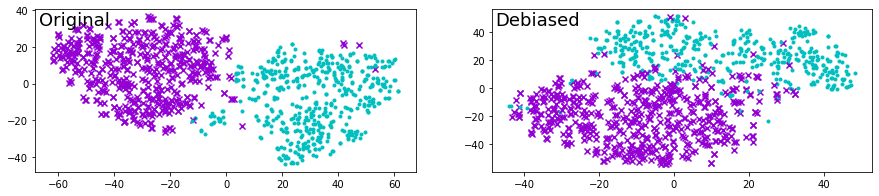

In [36]:
# Cluster most biased words before and after debiasing
import operator
import random
random.seed(1)
random_state = 1

size = 500
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
female = [item[0] for item in sorted_g[:size]]
male = [item[0] for item in sorted_g[-size:]]

X_bef, X_aft = extract_vectors(male + female)
y_true = [0]*size + [1]*size
cluster_and_visualize(male + female, X_bef, X_aft, random_state, y_true)


### Professions experiment

In [24]:
import json 

def extract_professions():
    professions = []
    with codecs.open('../data/lists/professions.json', 'r', 'utf-8') as f:
        professions_data = json.load(f)
    for item in professions_data:
        professions.append(item[0].strip())
    return professions


professions = extract_professions()


In [25]:
import scipy.stats

def get_tuples_prof(space, words, gender_bias_dict):

    tuples = []
    for w in words:
        if w not in gender_bias_dict:
            continue
            
        top = topK(w, space, k=105)[:100]
            
        m = 0
        f = 0  
        for t in top:          
            if gender_bias_dict[t] > 0:
                m+=1
            else:
                f+=1
                
        tuples.append((w, gender_bias_bef[w], gender_bias_aft[w], m, f))
        
    return tuples


tuples_bef_prof = get_tuples_prof('limit_bef', professions, gender_bias_bef)
tuples_aft_prof = get_tuples_prof('limit_aft', professions, gender_bias_bef)

compute_corr(tuples_bef_prof, 1, 3)
compute_corr(tuples_aft_prof, 1, 3)



(0.7560541675832431, 1.3982315385841456e-54)
(0.607720484165806, 1.817265631039899e-30)


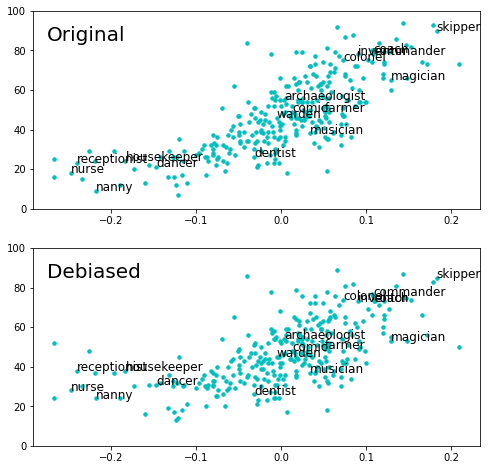

In [26]:
# Show plots

def show_plots(tuples_bef_prof, tuples_aft_prof):
    
    fig, axs = plt.subplots(2,1, figsize=(8,8))
    
    for i,(tuples, title) in enumerate(zip([tuples_bef_prof, tuples_aft_prof], ['Original', 'Debiased'])):
        X = []
        Y = []
        for t in tuples:
            X.append(t[1])
            Y.append(t[3])

        axs[i].scatter(X,Y, color = 'c', s=12)
        axs[i].set_ylim(0,100)
        
        for t in tuples:
            if t[0] in ['nanny', 'dancer', 'housekeeper', 'receptionist', 'nurse',\
                   'magician', 'musician', 'warden', 'archaeologist', 'comic', 'dentist', \
                    'inventor', 'colonel', 'farmer', 'skipper', 'commander', 'coach']:
                axs[i].annotate(t[0], xy=(t[1], t[3]), xytext=(t[1], t[3]), textcoords="data", fontsize=12) 
        axs[i].text(.03, .85, title, transform=axs[i].transAxes, fontsize=20)
    
    
    #fig.show()


show_plots(tuples_bef_prof, tuples_aft_prof)


### Classification experiment

In [27]:
# take 5000 most biased words, split each polarity randomly to train (1/5) and test (4/5), and predict

from sklearn import svm
from random import shuffle
import random
random.seed(10)



def train_and_predict(space_train, space_test):
    
    X_train = [wv[space_train][w2i[space_train][w],:] for w in males[:size_train]+females[:size_train]]
    Y_train = [1]*size_train + [0]*size_train
    X_test = [wv[space_test][w2i[space_test][w],:] for w in males[size_train:]+females[size_train:]]
    Y_test = [1]*size_test + [0]*size_test

    clf = svm.SVC()
    clf.fit(X_train, Y_train)

    print('train with', space_train)
    print('test with', space_test)

    preds = clf.predict(X_test)

    accuracy = [1 if y==z else 0 for y,z in zip(preds, Y_test)]
    print('accuracy:', float(sum(accuracy))/len(accuracy))

    
# extract nost biased words

size_train = 500
size_test = 2000
size = size_train + size_test
sorted_g = sorted(gender_bias_bef.items(), key=operator.itemgetter(1))
females = [item[0] for item in sorted_g[:size]]
males = [item[0] for item in sorted_g[-size:]]
for f in females:
    assert(gender_bias_bef[f] < 0)
for m in males:
    assert(gender_bias_bef[m] > 0)
shuffle(females)
shuffle(males)

# classification before debiasing

train_and_predict('bef', 'bef')

# classification after debiasing

train_and_predict('aft', 'aft')


train with bef
test with bef
accuracy: 0.99975
train with aft
test with aft
accuracy: 0.948


### Association Experiments (Calisken et al.)

In [28]:
# Auxiliary functions for experiments by Caliskan et al.

import scipy
import scipy.misc as misc
import itertools


def s_word(w, A, B, space, all_s_words):
    
    if w in all_s_words:
        return all_s_words[w]
    
    mean_a = []
    mean_b = []
    
    for a in A:
        mean_a.append(similarity(w, a, space))
    for b in B:
        mean_b.append(similarity(w, b, space))
        
    mean_a = sum(mean_a)/float(len(mean_a))
    mean_b = sum(mean_b)/float(len(mean_b))
    
    all_s_words[w] = mean_a - mean_b

    return all_s_words[w]


def s_group(X, Y, A, B, space, all_s_words):
    
    total = 0
    for x in X:
        total += s_word(x, A, B, space, all_s_words)
    for y in Y:
        total -= s_word(y, A, B, space, all_s_words)
        
    return total


def p_value_exhust(X, Y, A, B, space):
    
    if len(X) > 10:
        print('might take too long, use sampled version: p_value')
        return
    
    assert(len(X) == len(Y))
    
    all_s_words = {}
    s_orig = s_group(X, Y, A, B, space, all_s_words) 
    
    union = set(X+Y)
    subset_size = int(len(union)/2)
    
    larger = 0
    total = 0
    for subset in tqdm(set(itertools.combinations(union, subset_size))):
        total += 1
        Xi = list(set(subset))
        Yi = list(union - set(subset))
        if s_group(Xi, Yi, A, B, space, all_s_words) > s_orig:
            larger += 1
    print('num of samples', total)
    return larger/float(total)


def p_value_sample(X, Y, A, B, space):
    
    random.seed(10)
    np.random.seed(10)
    all_s_words = {}
    
    assert(len(X) == len(Y))
    length = len(X)
    
    s_orig = s_group(X, Y, A, B, space, all_s_words) 
    
    num_of_samples = min(1000000, int(scipy.special.comb(length*2,length)*100))
    print('num of samples', num_of_samples)
    larger = 0
    for i in range(num_of_samples):
        permute = np.random.permutation(X+Y)
        Xi = permute[:length]
        Yi = permute[length:]
        if s_group(Xi, Yi, A, B, space, all_s_words) > s_orig:
            larger += 1
    
    return larger/float(num_of_samples)



In [30]:
# Experiment 1

A = ['john', 'paul', 'mike', 'kevin', 'steve', 'greg', 'jeff', 'bill']
B = ['amy', 'joan', 'lisa', 'sarah', 'diana', 'kate', 'ann', 'donna']
C = ['executive', 'management', 'professional', 'corporation', 'salary', 'office', 'business', 'career']
D = ['home', 'parents', 'children', 'family', 'cousins', 'marriage', 'wedding', 'relatives']

print(p_value_exhust(A, B, C, D, 'aft'))

# Experiment 2

E = ['math', 'algebra', 'geometry', 'calculus', 'equations', 'computation', 'numbers', 'addition']
F = ['poetry', 'art', 'dance', 'literature', 'novel', 'symphony', 'drama', 'sculpture']

print(p_value_exhust(A, B, E, F, 'aft'))


# Experiment 3

G = ['science', 'technology', 'physics', 'chemistry', 'einstein', 'nasa', 'experiment', 'astronomy']
H = ['poetry', 'art', 'shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']

print(p_value_exhust(A, B, G, H, 'aft'))


100%|██████████| 12870/12870 [00:00<00:00, 175646.36it/s]

num of samples 12870
0.004273504273504274
num of samples 12870
0.43162393162393164
num of samples 12870
0.6899766899766899
